In [16]:
import os
# os.environ['CXX'] = '/usr/bin/g++'
# os.environ['CXXFLAGS'] = '-I/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/c++/v1'

#os.environ['CXXFLAGS'] = '-I/Library/Developer/CommandLineTools/usr/lib/clang/16/include -I/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include -I/Library/Developer/CommandLineTools/usr/include'
os.environ["PATH"] = "/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:" + os.environ["PATH"]
os.environ["PKG_CONFIG_PATH"] = "/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib/pkgconfig:" + os.environ.get("PKG_CONFIG_PATH", "")
os.environ["LD_LIBRARY_PATH"] = "/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib:" + os.environ.get("LD_LIBRARY_PATH", "")

# Verify if paths are set correctly
print("PATH:", os.environ["PATH"])
print("PKG_CONFIG_PATH:", os.environ["PKG_CONFIG_PATH"])
print("LD_LIBRARY_PATH:", os.environ["LD_LIBRARY_PATH"])

PATH: /Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/home/jt925938/anaconda3/envs/gempy_dino/bin:/rwthfs/rz/cluster/home/jt925938/.vscode-server/cli/servers/Stable-ddc367ed5c8936efe395cffeec279b04ffd7db78/server/bin/remote-cli:/home/jt925938/anaconda3/envs/gempy_dino/bin:/home/jt925938/anaconda3/condabin:/cvmfs/software.hpc.rwth.de/Linux/RH8/x86_64/intel/sapphirerapids/software/UCX/1.17.0-GCCcore-11.3.0/bin:/cvmfs/software.hpc.rwth.de/Linux/RH8/x86_64/intel/sapphirerapids/software/numactl/2.0.16-GCCcore-11.3.0/bin:/cvmfs/software.hpc.rwth.de/Linux/RH8/x86_64/intel/sapphirerapids/software/impi/2021.6.0-intel-compilers-2022.1.0/mpi/2021.6.0/libfabric/bin:/cvmfs/software.hpc.rwth.de/Linux/RH8/x86_64/intel/sapphirerapids/software/impi/2021.6.0-intel-compilers-2022.1.0/mpi/2021.6.0/bin:/cvmfs/software.hpc.rwth.de/Linux/RH8/

In [17]:
import dolfin as dl
import ufl

import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../") )
from hippylib import *

import logging
import math
import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt
%matplotlib inline

logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

# $ -\nabla  (k \nabla u) =f $
# Solve for 1D 
$$ - \nabla  (k \nabla u)  = x $$
# BC's are 
$$ u(0) = 0 $$
$$ u(1) = 1 $$

In [18]:
# create mesh and define function spaces
# Define mesh

# Get the MPI communicator
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()
    
comm.Barrier()
print(f"Process {rank} of {size}")

n = 999
mesh = dl.UnitIntervalMesh(n)  # 1D mesh with 50 elements
oder = 1
Vk = dl.FunctionSpace(mesh, 'Lagrange', 1)
Vu = dl.FunctionSpace(mesh, 'Lagrange', oder)

# # The true and inverted parameter
ktrue_expression = dl.Expression(
    '2',
    degree=0)
ktrue = dl.interpolate(ktrue_expression,Vk)

# ktrue = dl.Constant(2.0)
# define function for state and adjoint
u = dl.Function(Vu)
p = dl.Function(Vu)

# define Trial and Test Functions
u_trial, p_trial, k_trial = dl.TrialFunction(Vu), dl.TrialFunction(Vu), dl.TrialFunction(Vk)
u_test, p_test, k_test = dl.TestFunction(Vu), dl.TestFunction(Vu), dl.TestFunction(Vk)

# Define f(x) for the right-hand side (for simplicity, we choose f(x) = x)
f_expression = dl.Expression("x[0]", degree=1)
f = dl.interpolate(f_expression,Vu)  

class LeftBoundary(dl.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0]) < dl.DOLFIN_EPS

class RightBoundary(dl.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0] - 1) < dl.DOLFIN_EPS

boundary_parts = dl.MeshFunction("size_t", mesh, mesh.topology().dim()-1)
#boundary_parts = FacetFunction("size_t", mesh)
boundary_parts.set_all(0)


Gamma_left = LeftBoundary()
Gamma_left.mark(boundary_parts, 1)
Gamma_right = RightBoundary()
Gamma_right.mark(boundary_parts, 2)

u_L = dl.Constant(1.)
u_R = dl.Constant(0.)

bc_state = [dl.DirichletBC(Vu, u_L, boundary_parts, 1),
       dl.DirichletBC(Vu, u_R, boundary_parts, 2)]
bc_adj = [dl.DirichletBC(Vu, dl.Constant(0.), boundary_parts, 1),
       dl.DirichletBC(Vu, dl.Constant(0.), boundary_parts, 2)]



Process 0 of 1


# Weak form of the equation
$$(k \nabla u, \nabla p) - (f,p) =0$$

## If we add the PDE with cost fucntion with Langerange multiplier
$$L = (1, u) + (k \nabla u, \nabla p) - (f,p) $$
## Adjoint equation become
$$ (1, \tilde(u)) + (k \nabla \tilde(u), \nabla p) =0$$

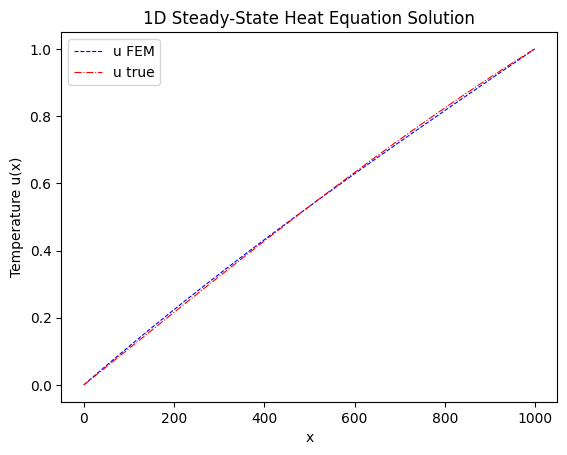

In [19]:
# We added our weak formulation to the cost functional to form the Langerangian 
##########################################################################################
# weak form for setting up the state equation
##########################################################################################

a_state = ufl.inner( ktrue * ufl.grad(u_trial), ufl.grad(u_test)) * ufl.dx
L_state = f * u_test * ufl.dx

###########################################################################################
# solve state equation
###########################################################################################

state_A, state_b = dl.assemble_system (a_state, L_state, bc_state)
dl.solve (state_A, u.vector(), state_b)

###########################################################################################
# weak form for setting up the adjoint equation
###########################################################################################
a_adj = ufl.inner( ktrue  * ufl.grad(p_trial), ufl.grad(p_test)) * ufl.dx
L_adj =   -1 * p_test * ufl.dx

adj_A, adj_b = dl.assemble_system (a_adj, L_adj, bc_adj)
dl.solve (adj_A, p.vector(), adj_b)


x_coord =mesh.coordinates()
x_coord = np.array(x_coord).reshape(-1)
u_true = -(x_coord**3)/12 + (1 + 1/12)*x_coord #(-x^3/6k + (1+1/6k)x) # Here k =2

# Plot the solution
plt.plot(u.vector().get_local()[::oder], label="u FEM",linestyle="--",  color="blue" ,linewidth=0.8)
plt.plot(u_true, label="u true", linestyle="-.",  color="red",linewidth=0.8)
plt.xlabel("x")
plt.ylabel("Temperature u(x)")
plt.title("1D Steady-State Heat Equation Solution")
# Show the legend
plt.legend()
plt.show()

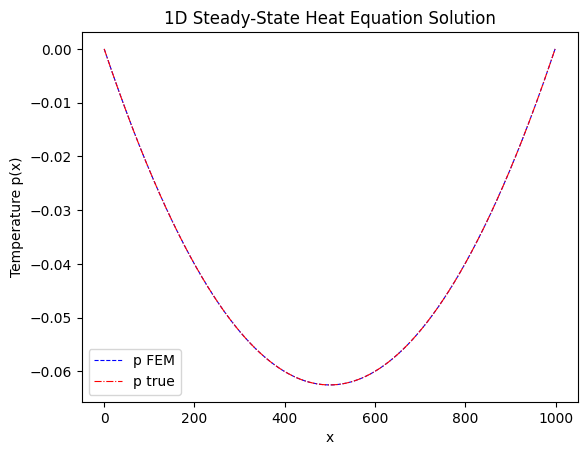

In [587]:
# Plot the solution
p_true = x_coord**2/ 4 - x_coord/4 # (x^2 - x)/ 2k

plt.plot(p.vector().get_local()[::oder], label="p FEM",linestyle="--",  color="blue" ,linewidth=0.8)
plt.plot(p_true, label="p true", linestyle="-.",  color="red",linewidth=0.8)
plt.xlabel("x")
plt.ylabel("Temperature p(x)")
plt.title("1D Steady-State Heat Equation Solution")
plt.legend()
plt.show()

In [588]:
a_adj = ufl.inner( ktrue  * ufl.grad(p_trial), ufl.grad(p_test)) * ufl.dx
L_adj =   dl.Constant(0) * p_test * ufl.dx

adj_A, adj_b = dl.assemble_system (a_adj, L_adj, bc_adj)
#print(adj_b.get_local())
adjoint = np.zeros_like(adj_A.array())
for i, x_0 in enumerate(mesh.coordinates()):
    if x_0 !=0.0 and x_0 !=1:
        adj_b[i] = -1
        # Step 5e: Solve the system
        p_sol = dl.Function(Vu)
        dl.solve (adj_A, p_sol.vector(), adj_b)
        adj_b[i] = 0
        adjoint[:,i] = p_sol.vector().get_local() #* u.vector().get_local()
#adjoint
#dl.solve (adj_A, p.vector(), adj_b)

In [589]:
x_coord = mesh.coordinates()
A_T = adj_A.array()

x_coord = mesh.coordinates()
Adjoint = np.zeros_like(A_T)
for i, _ in enumerate(x_coord):
    b = np.zeros(A_T.shape[0])
    b[i] = -1
    p_i = np.linalg.solve(A_T, b)
    Adjoint[:,i] = p_i 
#Adjoint

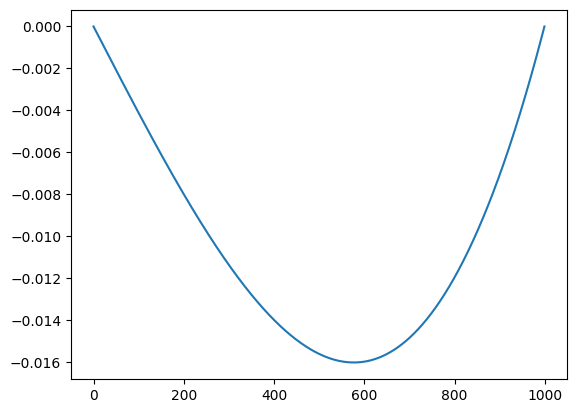

In [590]:
# Calcualte the analytical value of gradient du/dk
#u(x,k)= (-x^3/6k + (1+1/6k)x)
#  du/ dk = x^3/6k^2 - x/6k^2 = (x^3 -x)/ 6k^2
grad_u = (x_coord**3 - x_coord)/24 #+ (- x_coord**2/4 + 1 + 1/24)* (0.25)
#print(grad_u)
plt.plot(grad_u)

# To calculate Sensitivity, we get 

$$ (g, \tilde{k}) = (\tilde{k} \nabla u ,  \nabla p)$$
##  Discretization of above expression will create 
$$ Mg = C^T P$$
Where M is a mass matrix created by basis function of k $$M_{ij} = \int_{\Omega} \phi^k_i \phi^k_j d\Omega$$ and, $$ C_{ij} = \int_{\Omega} \phi^k_i (\nabla u) . (\nabla \phi^p_j) d\Omega$$
where $\phi^p_j$ is the basis function of adjoint variable p



In [591]:
C_equ   = ufl.inner( k_trial * ufl.grad(u), ufl.grad(p_test)) * ufl.dx
# assemble matrix C
C =  dl.assemble(C_equ)

g, m_delta = dl.Vector(), dl.Vector()

M_equ   = ufl.inner(k_trial, k_test) * ufl.dx

# assemble matrix M
M = dl.assemble(M_equ)
#print(u.vector().get_local())

#C.array()

In [592]:
h = 1/2
a = 0.53125
(a-1)/(2*h)


-0.46875

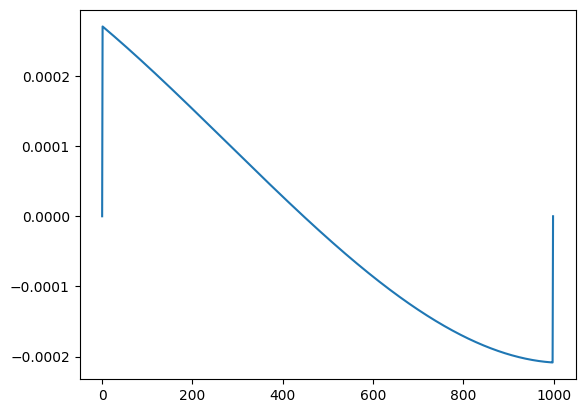

In [593]:
J = np.linalg.solve(M.array(),  adjoint.T @ C.array().T)
J = adjoint.T @ C.array().T
#print(J)
plt.plot(np.diag(J))

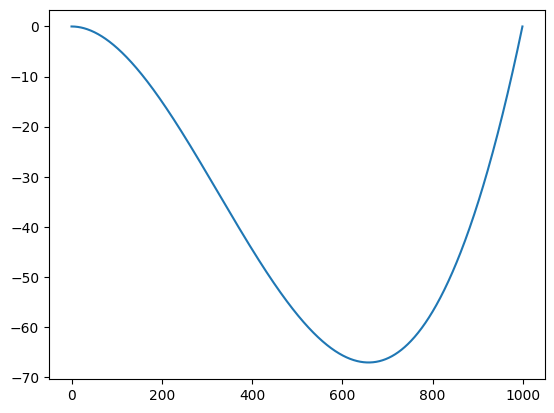

In [594]:
C_equ_2 = ufl.inner(ufl.dot(ufl.grad(u), ufl.grad(p)) , k_test) * ufl.dx
P_vector = p.vector().get_local()
U_vector = u.vector().get_local()
C_2 = dl.assemble(C_equ).array()
C_3 = np.eye(C_2.shape[0])
#C_3[:-1,:-1] = C_2[:-1,:-1]
#C_3[1:,1:] = C_2[1:,1:]
# C_3[1:-1,1:-1] = C_2[1:-1,1:-1]
C_2 = C_3
# C_2.array() , P_vector, U_vector, P_vector * U_vector

C_3 =  np.diag(P_vector * U_vector) @ C_2
M_ = np.eye(M.array().shape[0])
#M_[1:,1:] = M.array()[1:,1:]
#M_[:-1,:-1] = M.array()[:-1,:-1]
M_ = M.array()
plt.plot(np.diag(np.linalg.solve(M_,  C_3.T)))

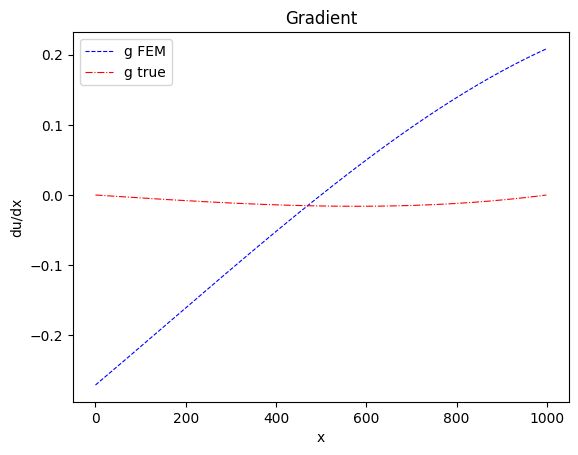

In [595]:
# evaluate the  gradient
CT_p = dl.Vector()
C.init_vector(CT_p,1)
C.transpmult(p.vector(), CT_p)
MG = CT_p
dl.solve(M, g, MG)

plt.plot(g.get_local()[::oder], label="g FEM",linestyle="--",  color="blue" ,linewidth=0.8)
plt.plot(grad_u[::oder], label="g true",linestyle="-.",  color="red" ,linewidth=0.8 )
plt.xlabel("x")
plt.ylabel("du/dx")
plt.title("Gradient")
plt.legend()
plt.show()

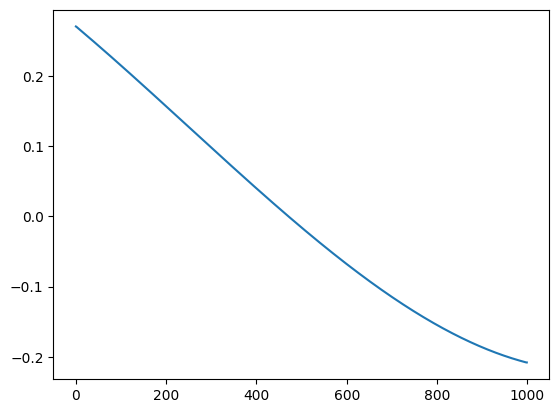

In [596]:
C_Matrix = C.array()
P_vector = p.vector().get_local()
M_matrix = M.array()
plt.plot(np.linalg.solve(M_matrix, (C_Matrix @ P_vector.reshape((-1,1)))))

(1000, 1000)


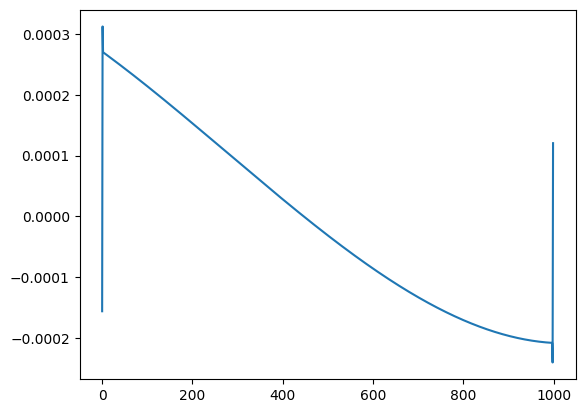

In [597]:
# Solve adjoint equation n times by consister the f function is each basis fucntion of p

num_dofs = Vu.dim()  # The number of degrees of freedom
solution_matrix = np.zeros((num_dofs, num_dofs))  # Each column will store a solution
store_p = []
solution_matrix_grad = np.zeros((num_dofs, num_dofs))
x_coord = mesh.coordinates()
# Step 5: Loop over all basis functions (degree of freedom)
for i, x_0 in enumerate(mesh.coordinates()):
    # Step 5a: Define the source term as one of the basis functions (phi_i)
    if x_0 !=0 and x_0!=1:
        f = dl.Function(Vu)
        f.vector()[i] = - 1  # Set the i-th degree of freedom to 1 (the basis function)

        # Step 5b: Define the linear form using f
        L_adj = f * u_test * dl.dx  # Linear form for the source term f
        
        b = dl.assemble(L_adj)  # Right-hand side
        adj_A, adj_b = dl.assemble_system (a_adj, L_adj, bc_adj)

        
        # Step 5e: Solve the system
        p_sol = dl.Function(Vu)
        dl.solve (adj_A, p_sol.vector(), adj_b)
        
        store_p.append(p_sol)
        # Step 5f: Store the result (solution vector) in the matrix as a column
        solution_matrix[:, i] = p_sol.vector().get_local()
   

C_matrix = C.array()
P_matrix = solution_matrix
M_matrix = M.array()
rhs =      C_matrix @ P_matrix
G = np.linalg.solve(M.array(), rhs.T)


num_dofs_m = Vk.dim()
store_g = np.zeros((num_dofs_m, num_dofs))
print(store_g.shape)
for i in range(len(store_p)):
    g_, m_delta = dl.Vector(), dl.Vector()
    CT_p = dl.Vector()
    C.init_vector(CT_p,1)
    C.transpmult(store_p[i].vector(), CT_p)
    MG = CT_p
    #print(M.array().shape, MG.get_local().shape)
    dl.solve(M, g_, MG)
    store_g[:,i] = g_.get_local()
    
# I am assuming that My Sensitivity matrix is calcualted with respect to each nodal point
# So if K is the value of conductivity at each node, then I will get du/dK and if K is a function of
# du/dk = du/dK * dK/dk 
plt.plot(np.diag(G)) 

#plt.plot(store_g.T @ np.ones((store_g.shape[1],1)))

In [598]:
#g.get_local()

In [599]:
f_expression = dl.Expression("-x[0]", degree=1)
f = dl.interpolate(f_expression,Vu)  # forcing term (f(x) = -x)
a =  - solution_matrix.T @ f.vector().get_local()/2 # P^T [Laplace u] = P^T f/k
#a

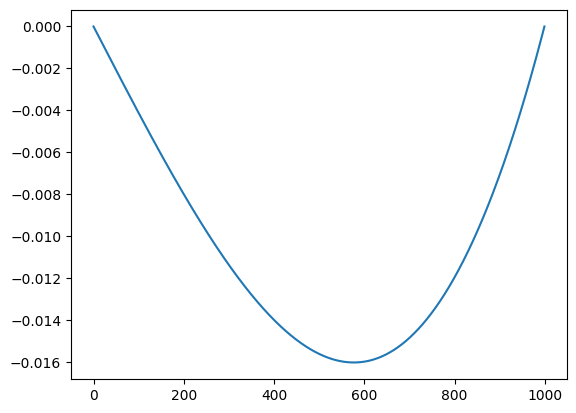

In [600]:
plt.plot(a)

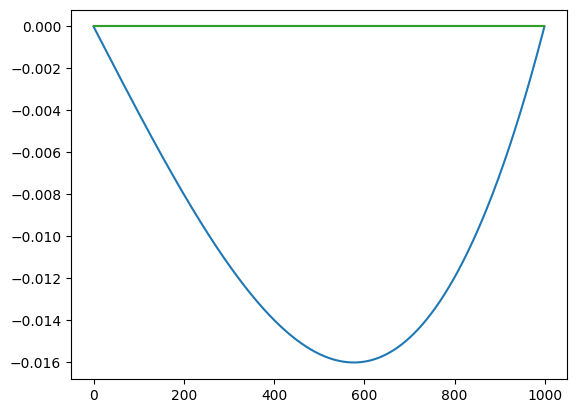

In [601]:
#plt.plot(a)
plt.plot(grad_u)
plt.plot(G @ np.ones((G.shape[0],1)))
plt.plot(np.sum(G, axis=1))
#plt.plot(np.diag(G))

# Test with Variable k for each point. k=x+1

In [422]:
# create mesh and define function spaces
# Define mesh
mesh = dl.UnitIntervalMesh(1000)  # 1D mesh with 50 elements
oder = 1
Vk = dl.FunctionSpace(mesh, 'Lagrange', 1)
Vu = dl.FunctionSpace(mesh, 'Lagrange', oder)

# # The true and inverted parameter
ktrue_expression = dl.Expression(
    '1+x[0]',
    degree=1)
ktrue = dl.interpolate(ktrue_expression,Vk)

#mtrue = dl.Constant(2.0)
# define function for state and adjoint
u = dl.Function(Vu)
p = dl.Function(Vu)

# define Trial and Test Functions
u_trial, p_trial, k_trial = dl.TrialFunction(Vu), dl.TrialFunction(Vu), dl.TrialFunction(Vk)
u_test, p_test, k_test = dl.TestFunction(Vu), dl.TestFunction(Vu), dl.TestFunction(Vk)

# Define f(x) for the right-hand side (for simplicity, we choose f(x) = -x)
f_expression = dl.Expression("-x[0]", degree=1)
f = dl.interpolate(f_expression,Vu)  # forcing term (f(x) = -x)

class LeftBoundary(dl.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0]) < dl.DOLFIN_EPS

class RightBoundary(dl.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0] - 1) < dl.DOLFIN_EPS

boundary_parts = dl.MeshFunction("size_t", mesh, mesh.topology().dim()-1)
#boundary_parts = FacetFunction("size_t", mesh)
boundary_parts.set_all(0)


Gamma_left = LeftBoundary()
Gamma_left.mark(boundary_parts, 1)
Gamma_right = RightBoundary()
Gamma_right.mark(boundary_parts, 2)

u_L = dl.Constant(0.)
u_R = dl.Constant(1.)

bc_state = [dl.DirichletBC(Vu, u_L, boundary_parts, 1),
       dl.DirichletBC(Vu, u_R, boundary_parts, 2)]
bc_adj = [dl.DirichletBC(Vu, dl.Constant(0.), boundary_parts, 1),
       dl.DirichletBC(Vu, dl.Constant(0.), boundary_parts, 2)]

# weak form for setting up the state equation
a_state = ufl.inner(ktrue * ufl.grad(u_trial), ufl.grad(u_test)) * ufl.dx
L_state = -f * u_test * ufl.dx

# weak form for setting up the adjoint equation
a_adj = ufl.inner(ktrue * ufl.grad(p_trial), ufl.grad(p_test)) * ufl.dx
L_adj =  - p_test * ufl.dx

# solve state equation
state_A, state_b = dl.assemble_system (a_state, L_state, bc_state)
dl.solve (state_A, u.vector(), state_b)

adj_A, adj_b = dl.assemble_system (a_adj, L_adj, bc_adj)
dl.solve (adj_A, p.vector(), adj_b)



1

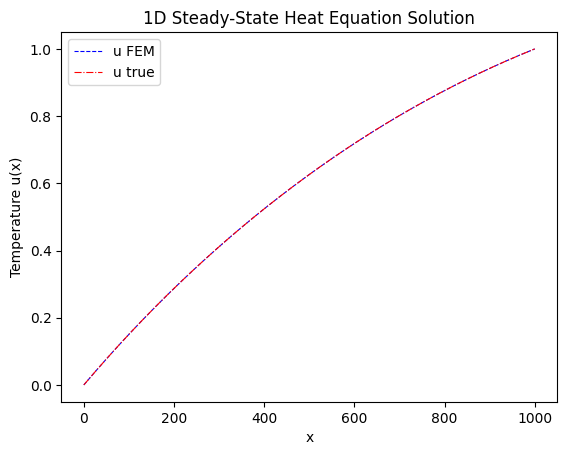

In [423]:
x_coord = mesh.coordinates()
# u_true = -x^2/4 + x/2 + 3/(4 ln2) * ln(k)
u_true = - x_coord**2/4 + x_coord/2 + (3/(np.log(16)))* np.log(1+x_coord)
plt.plot(u.vector().get_local()[::oder], label="u FEM",linestyle="--",  color="blue" ,linewidth=0.8)
plt.plot(u_true, label="u true", linestyle="-.",  color="red",linewidth=0.8)
plt.xlabel("x")
plt.ylabel("Temperature u(x)")
plt.title("1D Steady-State Heat Equation Solution")
# Show the legend
plt.legend()
plt.show()

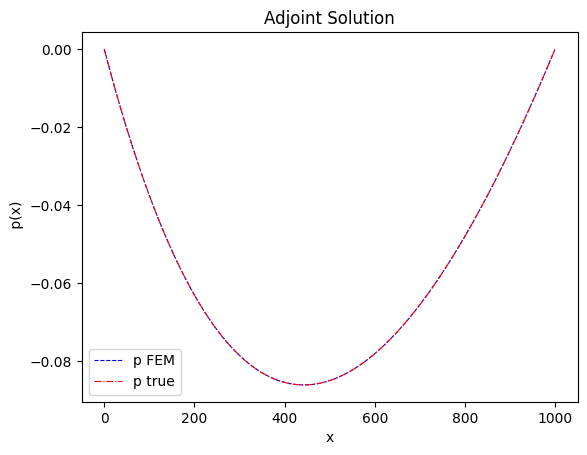

In [424]:
p_true =   x_coord - np.log(1+x_coord)/np.log(2) # x - ln(1+x)/ ln(2)
plt.plot(p.vector().get_local()[::oder], label="p FEM",linestyle="--",  color="blue" ,linewidth=0.8)
plt.plot(p_true, label="p true", linestyle="-.",  color="red",linewidth=0.8)
plt.xlabel("x")
plt.ylabel(" p(x)")
plt.title("Adjoint Solution")
# Show the legend
plt.legend()
plt.show()

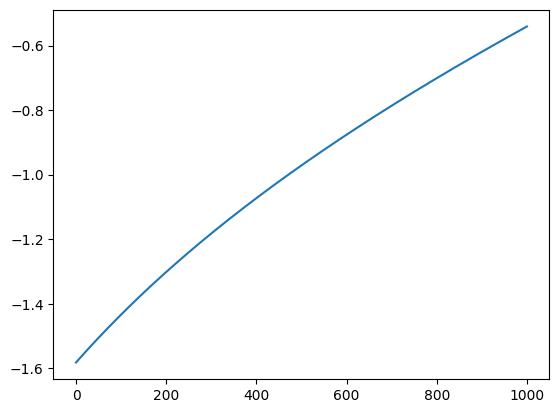

In [425]:
# Analytical gradient 
# du/dk = 0.5 + 3/(ln(16) * k) = 3/(ln(16) * (1+x))
grad_u = -(- x_coord/2 + 0.5 + 3/(np.log(16) * (1+x_coord)) )
plt.plot(grad_u)

In [426]:
C_equ   = ufl.inner( k_trial * ufl.grad(u), ufl.grad(u_test)) * ufl.dx
# assemble matrix C
C =  dl.assemble(C_equ)
g, m_delta = dl.Vector(), dl.Vector()

M_equ   = ufl.inner(k_trial, k_test) * ufl.dx

# assemble matrix M
M = dl.assemble(M_equ)

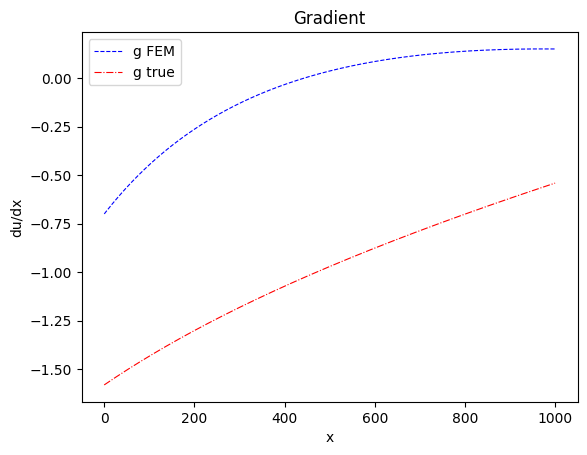

In [427]:
# evaluate the  gradient
CT_p = dl.Vector()
C.init_vector(CT_p,1)
C.transpmult(p.vector(), CT_p)
MG = CT_p
dl.solve(M, g, MG)

plt.plot(g.get_local()[::oder], label="g FEM",linestyle="--",  color="blue" ,linewidth=0.8)
plt.plot(grad_u, label="g true",linestyle="-.",  color="red" ,linewidth=0.8 )
plt.xlabel("x")
plt.ylabel("du/dx")
plt.title("Gradient")
plt.legend()
plt.show()

(1001, 1001)


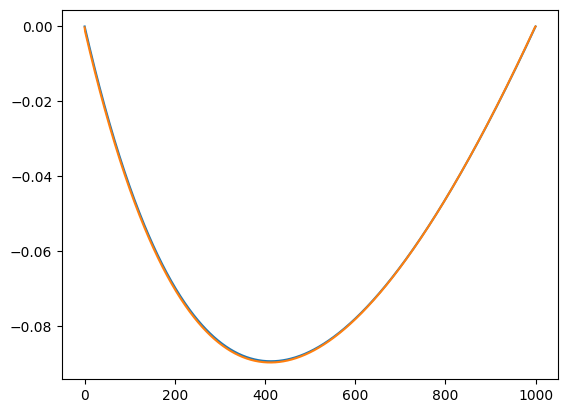

In [428]:
# Solve adjoint equation n times by consister the f function is each basis fucntion of p

num_dofs = Vu.dim()  # The number of degrees of freedom
solution_matrix = np.zeros((num_dofs, num_dofs))  # Each column will store a solution
store_p = []
solution_matrix_grad = np.zeros((num_dofs, num_dofs))
# Step 5: Loop over all basis functions (degree of freedom)
for i in range(num_dofs):
    # Step 5a: Define the source term as one of the basis functions (phi_i)
    f = dl.Function(Vu)
    f.vector()[i] = - 1  # Set the i-th degree of freedom to 1 (the basis function)

    # Step 5b: Define the linear form using f
    L_adj = f * u_test * dl.dx  # Linear form for the source term f
    
    b = dl.assemble(L_adj)  # Right-hand side
    adj_A, adj_b = dl.assemble_system (a_adj, L_adj, bc_adj)

    
    # Step 5e: Solve the system
    p_sol = dl.Function(Vu)
    dl.solve (adj_A, p_sol.vector(), adj_b)
    
    store_p.append(p_sol)
    # Step 5f: Store the result (solution vector) in the matrix as a column
    solution_matrix[:, i] = p_sol.vector().get_local()
   

C_matrix = C.array()
P_matrix = solution_matrix
M_matrix = M.array()
rhs =    P_matrix.T @ C_matrix 
G = np.linalg.solve(M.array(), rhs)


num_dofs_m = Vk.dim()
store_g = np.zeros((num_dofs_m, num_dofs))
print(store_g.shape)
for i in range(len(store_p)):
    g_, m_delta = dl.Vector(), dl.Vector()
    CT_p = dl.Vector()
    C.init_vector(CT_p,1)
    C.transpmult(store_p[i].vector(), CT_p)
    MG = CT_p
    #print(M.array().shape, MG.get_local().shape)
    dl.solve(M, g_, MG)
    store_g[:,i] = g_.get_local()
    
# I am assuming that My Sensitivity matrix is calcualted with respect to each nodal point
# So if K is the value of conductivity at each node, then I will get du/dK and if K is a function of
# du/dk = du/dK * dK/dk 
plt.plot(G @ np.ones((G.shape[1],1))) 
plt.plot(store_g.T @ np.ones((store_g.shape[1],1)))

In [429]:
#dU_dK = - x_coord/2 + 0.5 + 0.75/(np.log(2) * (1 + x_coord))
dU_dK = 0.75/(np.log(2) * (1 + x_coord))

In [430]:
P_matrix_2 = np.diag(p.vector().get_local())
rhs =  C_matrix.T @ P_matrix_2
S_T = np.linalg.solve(M.array(), rhs)
S_T_2 = np.linalg.solve(M.array(), C_matrix.T @ p.vector().get_local())

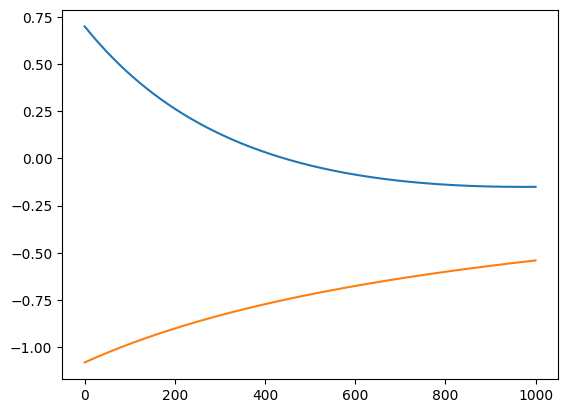

In [431]:
plt.plot(  - S_T @ np.ones((S_T.shape[0], 1) ))
#plt.plot(np.diag(S_T))
#plt.plot(np.ones((1, S_T.shape[0]) ) @ S_T)
#plt.plot(S_T_2)
plt.plot(-dU_dK)
#plt.plot(np.diag(S_T))


In [432]:
diag_G =np.diag(G)
diag_G


array([ 0.00000000e+00, -7.87943506e-04, -7.84100400e-04, ...,
        1.35251458e-04,  1.35187280e-04, -1.14617508e-20])

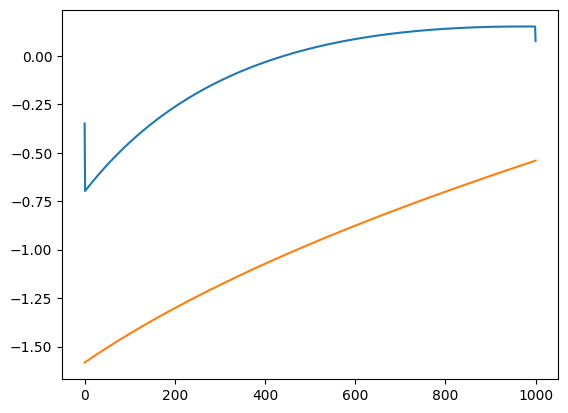

In [433]:
G_sum = np.sum(G, axis=1)
plt.plot(G.T @ np.ones((G.shape[0],1)))
plt.plot(grad_u)


In [434]:
A = P_matrix.T @ state_A.array() - M_matrix
A[A<1e-8]=0
A.sum()

0.0

In [435]:
np.sum(M_matrix != M_matrix.T)

0

In [436]:
# create mesh and define function spaces
# Define mesh
n = 4
mesh = dl.UnitIntervalMesh(n)  # 1D mesh with 50 elements
oder = 1
Vk = dl.FunctionSpace(mesh, 'Lagrange', 1)
Vu = dl.FunctionSpace(mesh, 'Lagrange', oder)

# # The true and inverted parameter
ktrue_expression = dl.Expression(
    '2 ',
    degree=0)
ktrue = dl.interpolate(ktrue_expression,Vk)

#mtrue = dl.Constant(2.0)
# define function for state and adjoint
u = dl.Function(Vu)
p = dl.Function(Vu)

# define Trial and Test Functions
u_trial, p_trial, k_trial = dl.TrialFunction(Vu), dl.TrialFunction(Vu), dl.TrialFunction(Vk)
u_test, p_test, k_test = dl.TestFunction(Vu), dl.TestFunction(Vu), dl.TestFunction(Vk)

# Define f(x) for the right-hand side (for simplicity, we choose f(x) = x)
f_expression = dl.Expression("x[0]", degree=1)
f = dl.interpolate(f_expression,Vu)  

class LeftBoundary(dl.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0]) < dl.DOLFIN_EPS

class RightBoundary(dl.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0] - 1) < dl.DOLFIN_EPS

boundary_parts = dl.MeshFunction("size_t", mesh, mesh.topology().dim()-1)
#boundary_parts = FacetFunction("size_t", mesh)
boundary_parts.set_all(0)


Gamma_left = LeftBoundary()
Gamma_left.mark(boundary_parts, 1)
Gamma_right = RightBoundary()
Gamma_right.mark(boundary_parts, 2)

u_L = dl.Constant(0.)
u_R = dl.Constant(1.)

bc_state = [dl.DirichletBC(Vu, u_L, boundary_parts, 1),
       dl.DirichletBC(Vu, u_R, boundary_parts, 2)]
bc_adj = [dl.DirichletBC(Vu, dl.Constant(0.), boundary_parts, 1),
       dl.DirichletBC(Vu, dl.Constant(0.), boundary_parts, 2)]

# weak form for setting up the state equation
a_state = ufl.inner(ktrue * ufl.grad(u_trial), ufl.grad(u_test)) * ufl.dx
L_state = f * u_test * ufl.dx


# solve state equation
state_A, state_b = dl.assemble_system (a_state, L_state, bc_state)
dl.solve (state_A, u.vector(), state_b)

# weak form for setting up the adjoint equation
a_adj = ufl.inner(ktrue * ufl.grad(p_trial), ufl.grad(p_test)) * ufl.dx
L_adj =  - ufl.inner( ufl.grad(u), ufl.grad(p_test)) * ufl.dx


# solve state equation
adj_A, adj_b = dl.assemble_system (a_adj, L_adj, bc_adj)
dl.solve (adj_A, p.vector(), adj_b)

x_coord = mesh.coordinates()

grad_u = (x_coord**3 - x_coord)/24 #(x^3-x)/6k^2
#grad_u = 5.4 *(x_coord**3 - x_coord)/(6 * (1 + 2 * x_coord)**2)
#grad_u = - x_coord/2 + 0.5 + 0.75/(np.log(2) * (1 + x_coord))

In [437]:
# del R/ del m = C 

C_equ = dl.inner(k_trial * dl.grad(u), dl.grad(u_test))* dl.dx
C= dl.assemble(C_equ)

C_T = C.array().T
C_T_ = np.eye(C_T.shape[0])
C_T_[1:-1, 1:-1] = C_T[1:-1, 1:-1]
C_T =C_T_#[1:-1, 1:-1]

print(C_T)
A = state_A.array() #[1:-1, 1:-1] 
print(A)
store_J = np.zeros((A.shape[0], C_T.shape[1]))
for i in range(C_T.shape[1]):
    J_i = np.linalg.solve(A,  C_T[:,i])
    store_J[:,i] = J_i

[[ 1.         0.         0.         0.         0.       ]
 [ 0.         0.015625   0.5234375  0.         0.       ]
 [ 0.        -0.5234375  0.03125    0.4921875  0.       ]
 [ 0.         0.        -0.4921875  0.046875   0.       ]
 [ 0.         0.         0.         0.         1.       ]]
[[ 1.  0.  0.  0.  0.]
 [ 0. 16. -8.  0.  0.]
 [ 0. -8. 16. -8.  0.]
 [ 0.  0. -8. 16.  0.]
 [ 0.  0.  0.  0.  1.]]


In [438]:
# dR_dk = ufl.inner( ufl.grad(u_trial), ufl.grad(u_test)) * ufl.dx
# DR_dk = dl.assemble(dR_dk)

# dU_dk_matrix = np.zeros((Vu.dim(), Vk.dim()))
# for i in range(Vk.dim()):
#     J_i = np.linalg.solve(state_A.array(), DR_dk.array()[:,i])
#     dU_dk_matrix[:, i] = J_i
# dU_dk_matrix.shape
# dU_dk_matrix

In [439]:
store_J

array([[ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.03125   ,  0.03564453,  0.03222656,  0.        ],
       [ 0.        , -0.06445312,  0.00585938,  0.06445312,  0.        ],
       [ 0.        , -0.03222656, -0.02783203,  0.03515625,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ]])

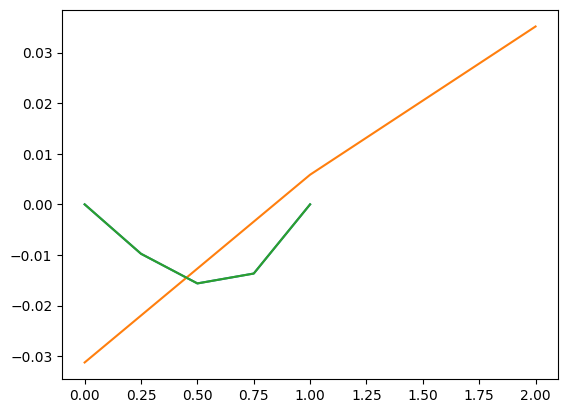

In [440]:

plt.plot(x_coord, p.vector().get_local())
plt.plot(np.diag(store_J)[1:-1])
plt.plot( x_coord, grad_u)

